# 2. Multi object detection

This notebook is motivated by fast.ai's course.

In [1]:
%matplotlib inline
# % load_ext autoreload
# % autoreload 2

In [2]:
import torch
import voc
from pathlib import Path

import numpy as np
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Pick one

In [3]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

## Contents

1. Defining the datasets

2. Anchor boxes

    2.1 Base anchor boxes
    
    2.2. Their permutations
3. Pre-training
    
    3.1. Maximum and mimimum learning rate
    
    3.2. Loss ratio

4. Training

5. Looking at results

    5.1. Without NMS
    
    5.2. With NMS

### 1. Defining the datasets

The dataset objects take as input a mask, which allow me to split the data into training and validation data.

In [4]:
total_dataset = voc.datasets.VOCDataset()

Now that we know the size of the dataset, we can use this to create a mask

In [5]:
train_mask = np.random.rand(len(total_dataset)) < 0.8
val_mask = ~train_mask

In [6]:
train_images = voc.datasets.MultiImageDataset(mask=train_mask, normalizer='imagenet', 
                                         random_transform=True, resize=(224, 224), device=device)

In [7]:
label2class = train_images.get_labels_from_classes()
normalizer = train_images.get_normalizer()
class2label = {int(im_class): label for label, im_class in label2class.items()}

In [8]:
val_images = voc.datasets.MultiImageDataset(mask=val_mask, normalizer='imagenet', resize=(224, 224),
                                       label2class=label2class, device=device)

In [9]:
im, bbs, labs = train_images.__getitem__(10)

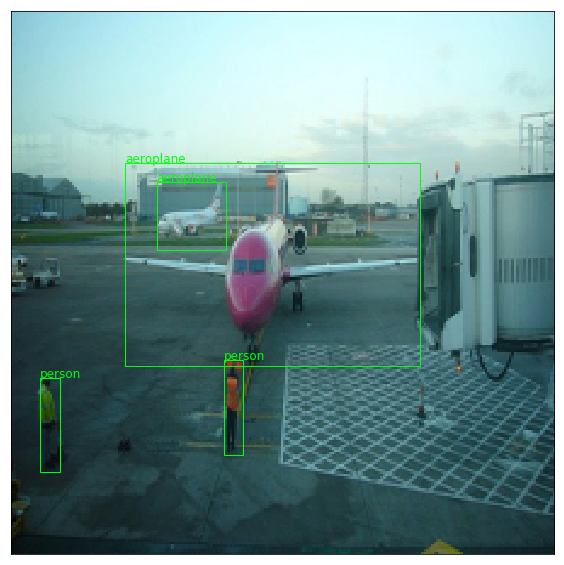

In [10]:
txt_labs = [class2label[idx.item()] for idx in labs]
denormed_im = voc.utils.denormalize(im.cpu().numpy(), mean=normalizer['mean'], std=normalizer['std'])
voc.explore.plot_image(denormed_im, bbs.cpu().numpy(), txt_labs)

Awesome. Now, in order to figure out which activations should find each of these objects, I need to do the following:

- Figure out what my **base** anchor boxes are going to be.
- Figure out what my **permuted** anchor boxes are going to be.

Then,

- Assign each ground truth bounding box to a **permuted** bounding box anchor

## 2. Anchor boxes

### 2.1. Getting the base bounding boxes, and their permutations

I am going to do this across 3 'depths', but I'll only visualize the `2 x 2` activations, to prevent the overlap from being confusing.

I'll start by considering an image of size `(1, 1)`, which I can then multiply by 224 to reflect the resnet-processed images.

In [10]:
import numpy as np

In [11]:
anchors_4 = voc.utils.make_anchors(224, 224, 0.25)
anchors_2 = voc.utils.make_anchors(224, 224, 0.5)
anchors_1 = voc.utils.make_anchors(224, 224, 1)

anchors = np.vstack((anchors_4, anchors_2, anchors_1))

Lets plot these bounding boxes, to see what they look like

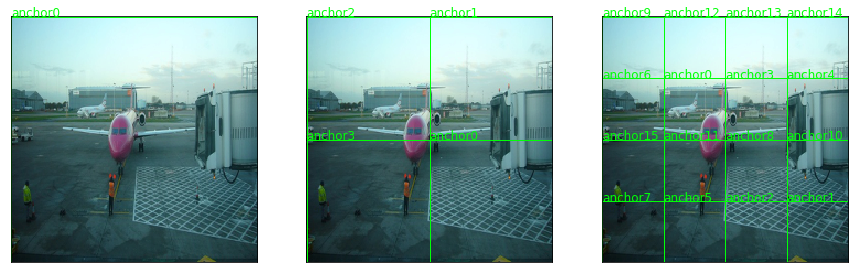

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

voc.explore.plot_image(denormed_im, anchors_1, labels=['anchor' + str(i) for i in range(len(anchors_1))], ax=ax[0])
voc.explore.plot_image(denormed_im, anchors_2, labels=['anchor' + str(i) for i in range(len(anchors_2))], ax=ax[1])
voc.explore.plot_image(denormed_im, anchors_4, labels=['anchor' + str(i) for i in range(len(anchors_4))], ax=ax[2])

Lets take a look at what these permuted anchors look like for the `2x2` boxes:

### 2.2. Permuting anchor boxes

In [11]:
pm_anc_2, num_permutations = voc.utils.permute_anchors(anchors_2, zooms=[1.3, 1., 0.7], 
                                                       ratios=[(1., 1.), (0.5, 1.), (1., 0.5)])

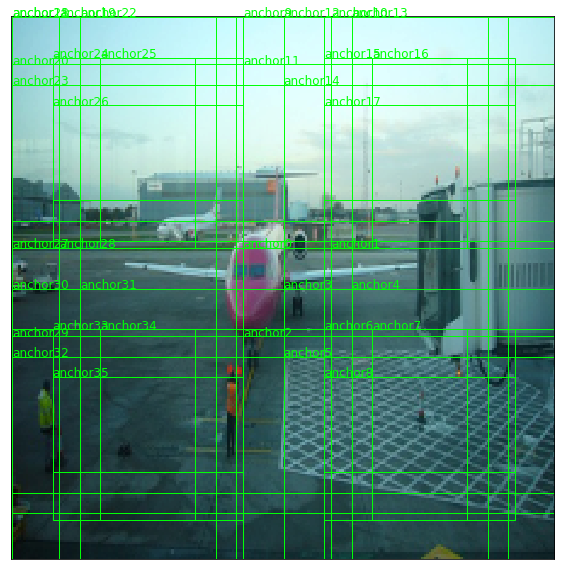

In [16]:
voc.explore.plot_image(denormed_im, pm_anc_2, labels=['anchor' + str(i) for i in range(len(pm_anc_2))])

Now, for all the boxes:

In [12]:
pm_anc, num_permutations = voc.utils.permute_anchors(anchors, zooms=[0.7, 1, 1.3], 
                                                     ratios=[(1., 1.), (0.5, 1.), (1., 0.5)])

In [13]:
num_permutations

9

In [14]:
pm_anc_tensor = torch.from_numpy(pm_anc).float().cuda()

## 3. Training

### 3.1. Maximum and Minimum Learning rate

Now that I have defined these anchor boxes, I can find the minimum and maximum learning rates

In [16]:
test_ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

# initialize the weights using xavier initialization
for name, layer_weight in test_ssd.named_parameters():
    if ('pretrained' not in name) & (len(layer_weight.size()) > 1):
        torch.nn.init.xavier_uniform_(layer_weight)

In [15]:
criterion = voc.models.SSDLoss(anchors=pm_anc_tensor, threshold=0.4, num_classes=len(label2class), device=device)

In [16]:
test_dataloader = DataLoader(train_images, batch_size=64, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)

In [17]:
starting_learning_rate = 1e-5
ending_learning_rate = 1

total_loss = []
learning_rate_progression = []

parameters_to_update = [parameters for name, parameters in test_ssd.named_parameters() if 'pretrained' not in name]

for batch_number, batch in (enumerate(tqdm(test_dataloader))):
    
        addition = (batch_number / len(test_dataloader)) * (ending_learning_rate - starting_learning_rate)
        learning_rate = starting_learning_rate + addition
        # create a new optimizer with higher learning rates
        optimizer = torch.optim.Adam(parameters_to_update, lr=learning_rate)
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = test_ssd(ims)
        bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
        loss = bb_loss + label_loss
        learning_rate_progression.append(learning_rate)
        total_loss.append(loss)
        loss.backward()
        optimizer.step()

100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


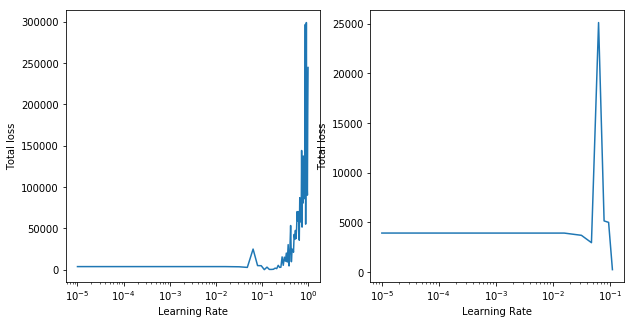

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# First, lets plot the results from the whole test
axes[0].plot(learning_rate_progression, total_loss)
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Total loss')
axes[0].set_xscale('log')

# then, clipped
axes[1].plot(learning_rate_progression[:8], total_loss[:8])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Total loss')
axes[1].set_xscale('log')

In [17]:
min_lr = 1e-5
max_lr = 1e-2

In addition, I am going to find the weight (`alpha` in the SSD paper)

### 3.2. Loss weight

In [ ]:
# once again, defining a test model
test_ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

# initialize the weights using xavier initialization
for name, layer_weight in test_ssd.named_parameters():
    if ('pretrained' not in name) & (len(layer_weight.size()) > 1):
        torch.nn.init.xavier_uniform_(layer_weight)

                
stepsize = int(len(test_dataloader) + 1 / 2)
parameters_to_update = [parameters for name, parameters in test_ssd.named_parameters() if 'pretrained' not in name]
optimizer = torch.optim.Adam(parameters_to_update)
cl_scheduler = voc.schedulers.CyclicalLR(optimizer, stepsize, min_lr, max_lr)

for batch_number, batch in (enumerate(tqdm(test_dataloader))):
    # Zero the gradients of my optimizer - 'reset' it
    optimizer.zero_grad()

    ims, target_bb, target_label = batch
    output_bb, output_labels = test_ssd(ims)

    bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
    loss = bb_loss + label_loss
    loss.backward()
    optimizer.step()
    # note that the step happens every batch, not every epoch
    cl_scheduler.step()

In [19]:
loss_weight = (bb_loss / label_loss).detach()

In [20]:
loss_weight

tensor(9.3937, device='cuda:0')

Now, we can define our model, and our optimizer

In [21]:
ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

Using Xavier initialization for the non-pretrained layers

In [22]:
# initialize the weights using xavier initialization
for name, layer_weight in test_ssd.named_parameters():
    if ('pretrained' not in name) & (len(layer_weight.size()) > 1):
        torch.nn.init.xavier_uniform_(layer_weight)

In [23]:
train_dataloader = DataLoader(train_images, batch_size=32, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)
val_dataloader = DataLoader(val_images, batch_size=32, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)

In [24]:
parameters_to_update = [parameters for name, parameters in ssd.named_parameters() if 'pretrained' not in name]
optimizer = torch.optim.Adam(parameters_to_update)

In [25]:
stepsize = int(len(train_dataloader) + 1 / 2)

In [26]:
cl_scheduler = voc.schedulers.CyclicalLR(optimizer, stepsize, min_lr, max_lr)

In [24]:
lr_change = cl_scheduler.test()

Text(0,0.5,'Learning rate')

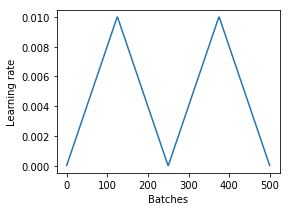

In [24]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(range(len(lr_change)), lr_change)
ax.set_xlabel('Batches')
ax.set_ylabel('Learning rate')

Finally, I can train the model

## 4. Training

In [27]:
num_epochs = 100
patience = 5
best_val_loss = np.inf
patience_counter = 0

In [28]:
for epoch in range(num_epochs):
    # set model to train
    ssd.train()

    # Keep track of my loss, so I can display it
    running_train_scores = defaultdict(list)
    
    # Iterate through my batches
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = ssd(ims)

        bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
        loss = bb_loss + (loss_weight * label_loss)
        loss.backward()
        optimizer.step()
        # For display purposes:
        running_train_scores['loss'].append(loss.item())
        running_train_scores['bb_loss'].append(bb_loss.item())
        running_train_scores['label_loss'].append(label_loss.item())
        # note that the step happens every batch, not every epoch
        cl_scheduler.step()

    train_output_strings = []
    for key, val in running_train_scores.items():
        train_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))

    # now, lets see how we did on the validation set
    if val_dataloader:
        ssd.eval()
        running_val_scores = defaultdict(list)
        with torch.no_grad():
            for batch_number, batch in (enumerate(val_dataloader)):
                val_ims, val_bb, val_lab = batch
                output_bb, output_labels = ssd(val_ims)
                val_bb_loss, val_label_loss = criterion(val_bb, val_lab, output_bb, output_labels)
                val_loss = val_bb_loss + (loss_weight * val_label_loss)
                running_val_scores['loss'].append(val_loss)
                running_val_scores['bb_loss'].append(val_bb_loss)
                running_val_scores['label_loss'].append(val_label_loss)
                
            # early stopping
            total_val_loss = np.array(running_val_scores['loss']).mean()
            if total_val_loss < best_val_loss:
                print('Saving model')
                best_val_loss = total_val_loss
                patience_counter = 0
                model_information = {
                    'state_dict': ssd.state_dict()
                }
                torch.save(model_information, 'ssd.pth.tar')
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print('Early stopping')
                    break
            
        val_output_strings = []
        for key, val in running_val_scores.items():
            val_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}, {}'.format(*val_output_strings))

100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 9.30666, bb_loss: 0.7146, label_loss: 0.91466
VALIDATION: loss: 1.6663299798965454, bb_loss: 0.966949999332428, label_loss: 0.07445000112056732


100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.57471, bb_loss: 0.90953, label_loss: 0.07081
VALIDATION: loss: 1.3114800453186035, bb_loss: 0.6620200276374817, label_loss: 0.0691400021314621


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.39105, bb_loss: 0.75222, label_loss: 0.06801
VALIDATION: loss: 1.3938000202178955, bb_loss: 0.7505699992179871, label_loss: 0.06847000122070312


100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.30013, bb_loss: 0.67503, label_loss: 0.06654
VALIDATION: loss: 1.1602799892425537, bb_loss: 0.5479999780654907, label_loss: 0.06518000364303589


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.17469, bb_loss: 0.56435, label_loss: 0.06497
VALIDATION: loss: 1.1690599918365479, bb_loss: 0.5448099970817566, label_loss: 0.06644999980926514


100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.14575, bb_loss: 0.54038, label_loss: 0.06444
VALIDATION: loss: 1.0783100128173828, bb_loss: 0.48278000950813293, label_loss: 0.06340000033378601


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.09087, bb_loss: 0.49786, label_loss: 0.06313
VALIDATION: loss: 1.1192899942398071, bb_loss: 0.5086100101470947, label_loss: 0.06500999629497528


100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.10251, bb_loss: 0.51136, label_loss: 0.06293
VALIDATION: loss: 1.0538300275802612, bb_loss: 0.4695900082588196, label_loss: 0.06218999996781349


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.06867, bb_loss: 0.48984, label_loss: 0.06162
VALIDATION: loss: 1.1127099990844727, bb_loss: 0.5103999972343445, label_loss: 0.06412000209093094


100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.06656, bb_loss: 0.49049, label_loss: 0.06132
VALIDATION: loss: 1.0226600170135498, bb_loss: 0.45124000310897827, label_loss: 0.060830000787973404


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.0378, bb_loss: 0.47399, label_loss: 0.06002
VALIDATION: loss: 1.0846099853515625, bb_loss: 0.5036500096321106, label_loss: 0.0618400014936924


100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.04358, bb_loss: 0.47904, label_loss: 0.0601
VALIDATION: loss: 0.9877700209617615, bb_loss: 0.426829993724823, label_loss: 0.059709999710321426


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.9978, bb_loss: 0.4484, label_loss: 0.05849
VALIDATION: loss: 1.0288200378417969, bb_loss: 0.4593699872493744, label_loss: 0.06061999872326851


100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 1.00205, bb_loss: 0.44602, label_loss: 0.05919
VALIDATION: loss: 0.9339399933815002, bb_loss: 0.38210999965667725, label_loss: 0.058740001171827316


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.94474, bb_loss: 0.40321, label_loss: 0.05765
VALIDATION: loss: 0.9628099799156189, bb_loss: 0.3999899923801422, label_loss: 0.05990999937057495


100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.88064, bb_loss: 0.33058, label_loss: 0.05856
VALIDATION: loss: 0.7726500034332275, bb_loss: 0.2174600064754486, label_loss: 0.05909999832510948


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.81402, bb_loss: 0.26585, label_loss: 0.05835
VALIDATION: loss: 0.7880200147628784, bb_loss: 0.2257699966430664, label_loss: 0.059849999845027924


100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.7947, bb_loss: 0.24713, label_loss: 0.05829
VALIDATION: loss: 0.7115200161933899, bb_loss: 0.1668899953365326, label_loss: 0.0579800009727478


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.76045, bb_loss: 0.21935, label_loss: 0.0576
VALIDATION: loss: 0.7605699896812439, bb_loss: 0.20284000039100647, label_loss: 0.059369999915361404


100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.76598, bb_loss: 0.22485, label_loss: 0.05761
VALIDATION: loss: 0.6977099776268005, bb_loss: 0.16190999746322632, label_loss: 0.05703999847173691


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.73692, bb_loss: 0.20516, label_loss: 0.05661
VALIDATION: loss: 0.750249981880188, bb_loss: 0.19588999450206757, label_loss: 0.05900999903678894


100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.74576, bb_loss: 0.2121, label_loss: 0.05681
VALIDATION: loss: 0.6876400113105774, bb_loss: 0.157150000333786, label_loss: 0.05646999925374985


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.71862, bb_loss: 0.19606, label_loss: 0.05563
VALIDATION: loss: 0.7272099852561951, bb_loss: 0.1821500062942505, label_loss: 0.05801999941468239


100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.73333, bb_loss: 0.20632, label_loss: 0.0561
VALIDATION: loss: 0.6792899966239929, bb_loss: 0.15383000671863556, label_loss: 0.05593999847769737


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.70333, bb_loss: 0.19048, label_loss: 0.05459
VALIDATION: loss: 0.7262499928474426, bb_loss: 0.18595999479293823, label_loss: 0.05751999840140343


100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.72536, bb_loss: 0.206, label_loss: 0.05529
VALIDATION: loss: 0.6701899766921997, bb_loss: 0.15014000236988068, label_loss: 0.05536000058054924


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.70049, bb_loss: 0.18987, label_loss: 0.05436
VALIDATION: loss: 0.7045599818229675, bb_loss: 0.1764799952507019, label_loss: 0.05621999874711037


100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.71323, bb_loss: 0.20161, label_loss: 0.05446
VALIDATION: loss: 0.6691499948501587, bb_loss: 0.15384000539779663, label_loss: 0.05485999956727028


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.68985, bb_loss: 0.18698, label_loss: 0.05353
VALIDATION: loss: 0.733739972114563, bb_loss: 0.18708999454975128, label_loss: 0.0581899993121624


100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.70928, bb_loss: 0.19622, label_loss: 0.05462
VALIDATION: loss: 0.664929986000061, bb_loss: 0.1517300009727478, label_loss: 0.05463000014424324


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.68857, bb_loss: 0.18624, label_loss: 0.05348
VALIDATION: loss: 0.7390699982643127, bb_loss: 0.1842299997806549, label_loss: 0.059059999883174896


100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.70171, bb_loss: 0.19543, label_loss: 0.0539
VALIDATION: loss: 0.6629599928855896, bb_loss: 0.151869997382164, label_loss: 0.054409999400377274


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.68479, bb_loss: 0.18487, label_loss: 0.05322
VALIDATION: loss: 0.7444900274276733, bb_loss: 0.1937599927186966, label_loss: 0.05863000079989433


100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.70311, bb_loss: 0.19748, label_loss: 0.05383
VALIDATION: loss: 0.6613699793815613, bb_loss: 0.14993999898433685, label_loss: 0.05443999916315079


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.67277, bb_loss: 0.18111, label_loss: 0.05234
VALIDATION: loss: 0.7242599725723267, bb_loss: 0.18973000347614288, label_loss: 0.05689999833703041


100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.70048, bb_loss: 0.19625, label_loss: 0.05368
VALIDATION: loss: 0.6545000076293945, bb_loss: 0.1487800031900406, label_loss: 0.05384000018239021


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.66632, bb_loss: 0.17918, label_loss: 0.05186
VALIDATION: loss: 0.7094699740409851, bb_loss: 0.18014000356197357, label_loss: 0.05635000020265579


100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.68692, bb_loss: 0.19186, label_loss: 0.0527
VALIDATION: loss: 0.6510999798774719, bb_loss: 0.14871999621391296, label_loss: 0.05347999930381775


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.6665, bb_loss: 0.18171, label_loss: 0.05161
VALIDATION: loss: 0.7067199945449829, bb_loss: 0.19099000096321106, label_loss: 0.05490000173449516


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.68723, bb_loss: 0.19306, label_loss: 0.05261
VALIDATION: loss: 0.6533300280570984, bb_loss: 0.15083999931812286, label_loss: 0.05349000170826912


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.66396, bb_loss: 0.18031, label_loss: 0.05149
VALIDATION: loss: 0.6951299905776978, bb_loss: 0.17260000109672546, label_loss: 0.055629998445510864


100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.69113, bb_loss: 0.19313, label_loss: 0.05301
VALIDATION: loss: 0.649869978427887, bb_loss: 0.14895999431610107, label_loss: 0.05332000181078911


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.65845, bb_loss: 0.17874, label_loss: 0.05107
VALIDATION: loss: 0.7016000151634216, bb_loss: 0.17782999575138092, label_loss: 0.05575999990105629


100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.69037, bb_loss: 0.19592, label_loss: 0.05264
VALIDATION: loss: 0.6463900208473206, bb_loss: 0.15020999312400818, label_loss: 0.05282000079751015


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.65175, bb_loss: 0.17686, label_loss: 0.05055
VALIDATION: loss: 0.6937400102615356, bb_loss: 0.18152999877929688, label_loss: 0.05452999845147133


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.68425, bb_loss: 0.19478, label_loss: 0.05211
VALIDATION: loss: 0.6477000117301941, bb_loss: 0.14981000125408173, label_loss: 0.05299999937415123


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.65013, bb_loss: 0.17665, label_loss: 0.0504
VALIDATION: loss: 0.7031700015068054, bb_loss: 0.17768999934196472, label_loss: 0.05593999847769737


100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Saving model


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.667, bb_loss: 0.19171, label_loss: 0.0506
VALIDATION: loss: 0.6451699733734131, bb_loss: 0.14855000376701355, label_loss: 0.0528700016438961


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.64855, bb_loss: 0.17639, label_loss: 0.05026
VALIDATION: loss: 0.7094500064849854, bb_loss: 0.18344999849796295, label_loss: 0.05598999932408333


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.66824, bb_loss: 0.19169, label_loss: 0.05073
VALIDATION: loss: 0.6475300192832947, bb_loss: 0.15035000443458557, label_loss: 0.05293000116944313


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.64586, bb_loss: 0.17494, label_loss: 0.05013
VALIDATION: loss: 0.7155399918556213, bb_loss: 0.18316000699996948, label_loss: 0.05666999891400337


  0%|          | 0/126 [00:00<?, ?it/s]

TRAINING: loss: 0.6721, bb_loss: 0.19086, label_loss: 0.05123
VALIDATION: loss: 0.6467499732971191, bb_loss: 0.14810000360012054, label_loss: 0.0530799999833107


100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Early stopping


## 5. Looking at results

In [29]:
imagenet = train_images.get_normalizer()

In [30]:
model = torch.load('ssd.pth.tar')
trained_model = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()
trained_model.load_state_dict(model['state_dict'])

In [31]:
trained_model.eval();

In [38]:
val_ims, bbs, labels = next(iter(val_dataloader))

In [39]:
with torch.no_grad():
    output_bb, output_labels = trained_model(val_ims)

In [40]:
bb_to_plot = output_bb[:10]
lab_to_plot = output_labels[:10]
im_to_plot = val_ims[:10].detach().cpu().numpy()

In [41]:
denormed_ims = [voc.utils.denormalize(im, imagenet['mean'], imagenet['std']) for im in im_to_plot]

## 4.1. Without NMS

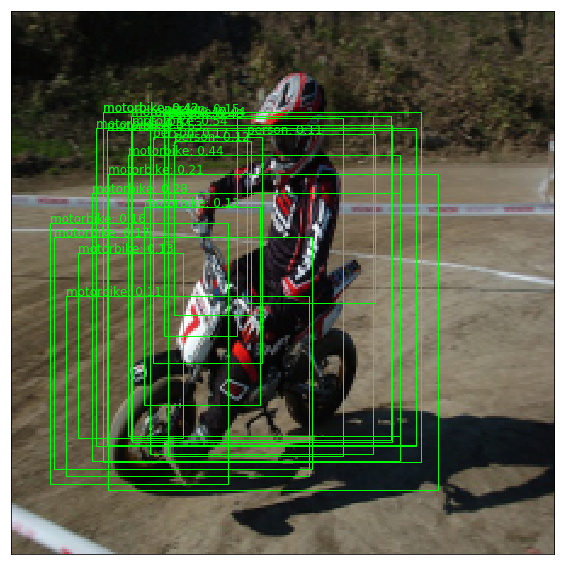

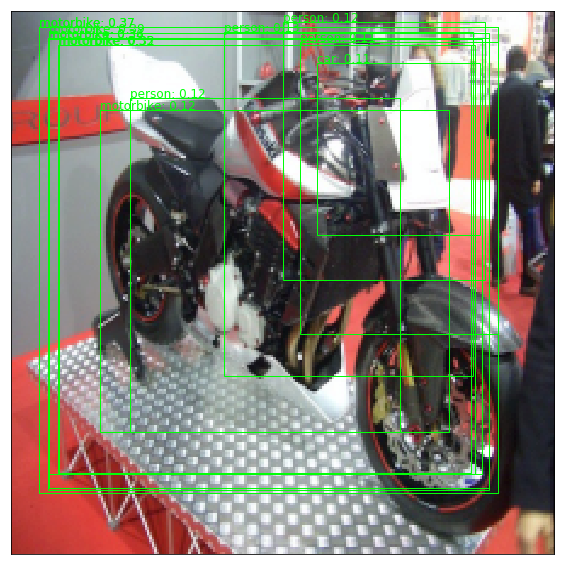

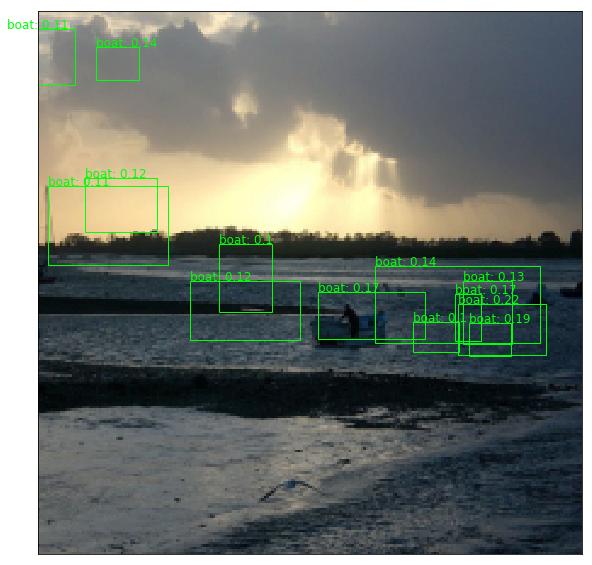

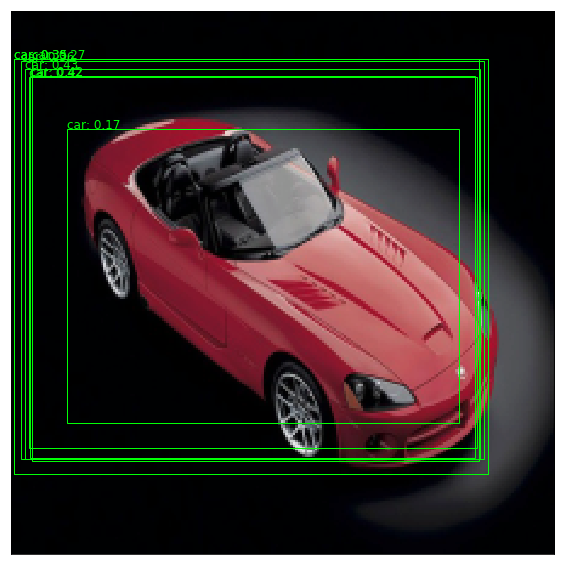

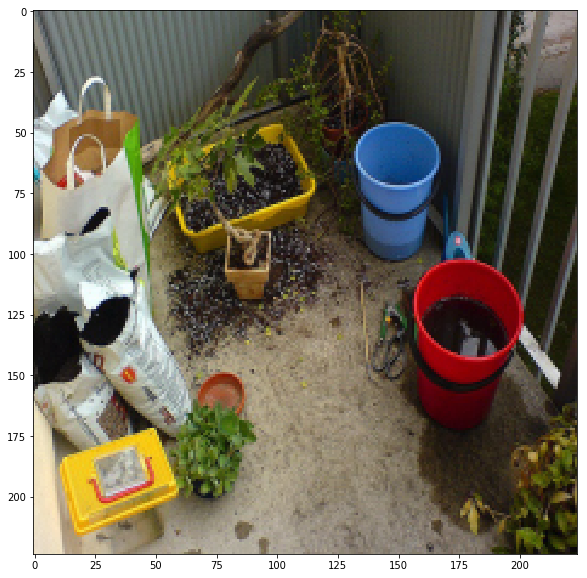

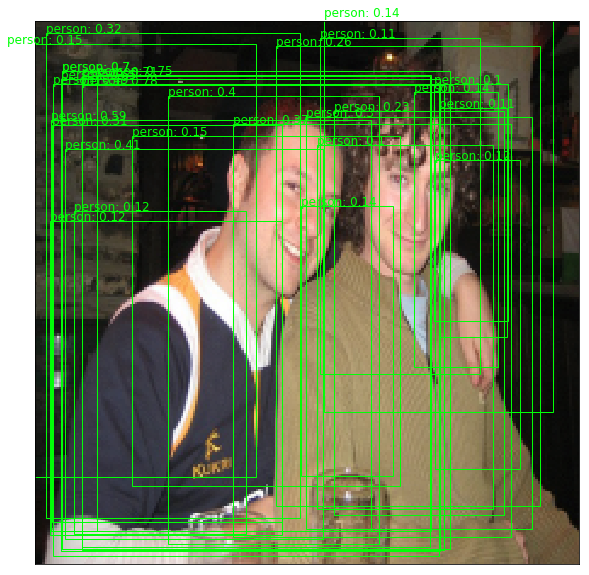

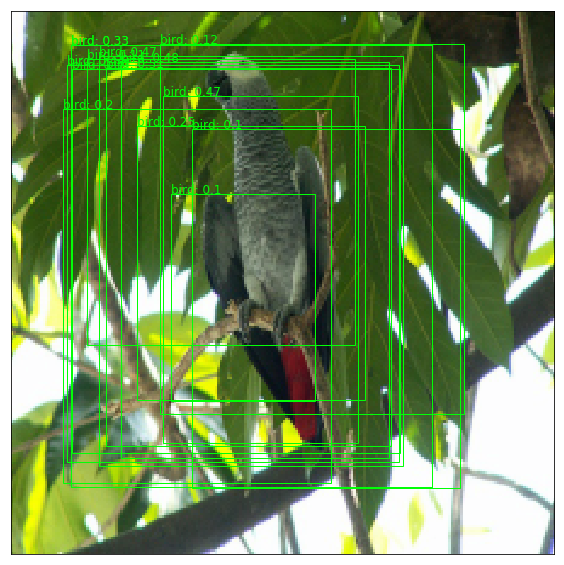

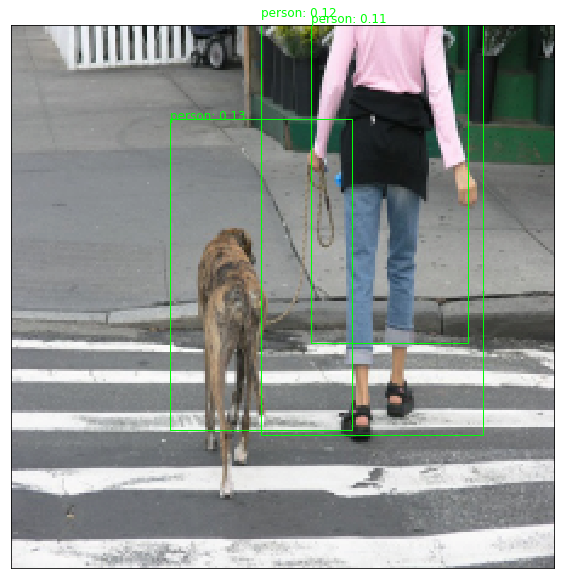

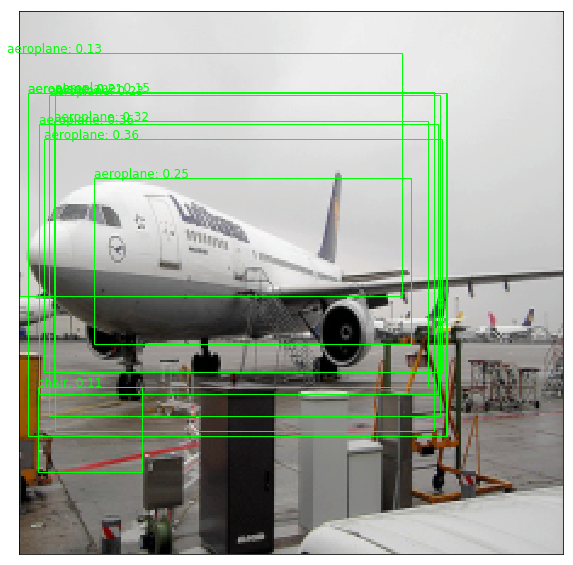

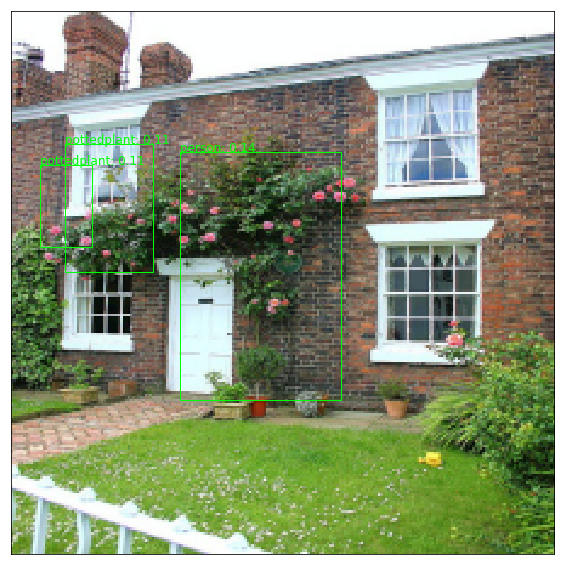

In [42]:
for im, bb, lab in zip(denormed_ims, bb_to_plot, lab_to_plot):
    voc.explore.plot_multiobject_results(im, bb, lab, pm_anc_tensor / 244, label2class, threshold=0.1, use_nms=False)

## 4.2. With NMS

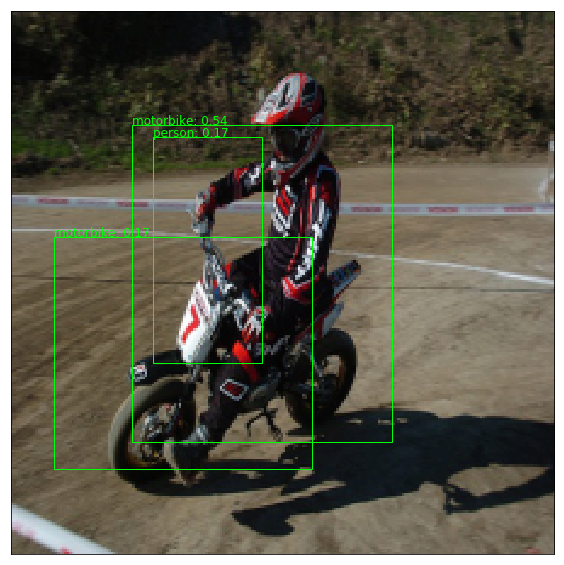

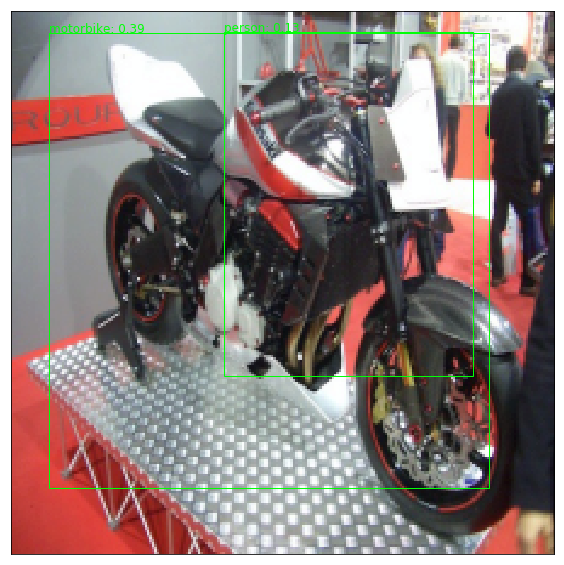

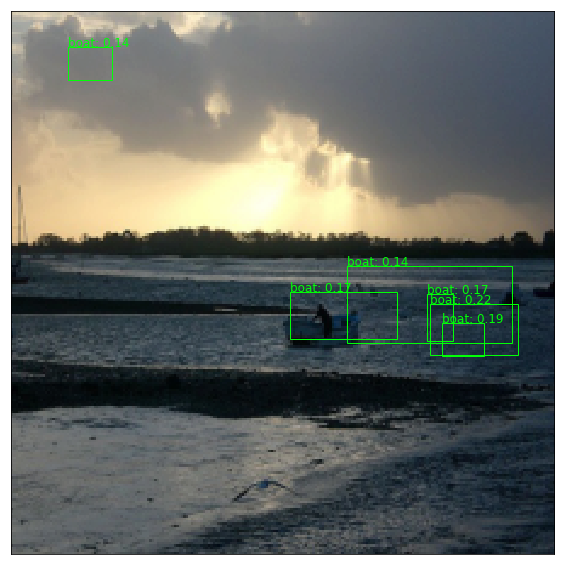

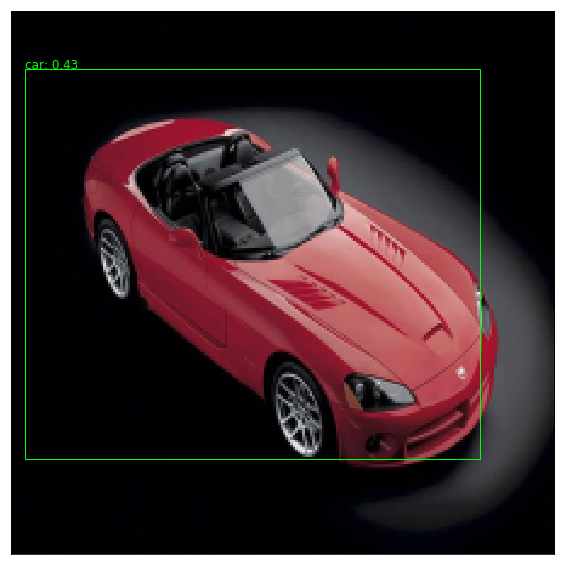

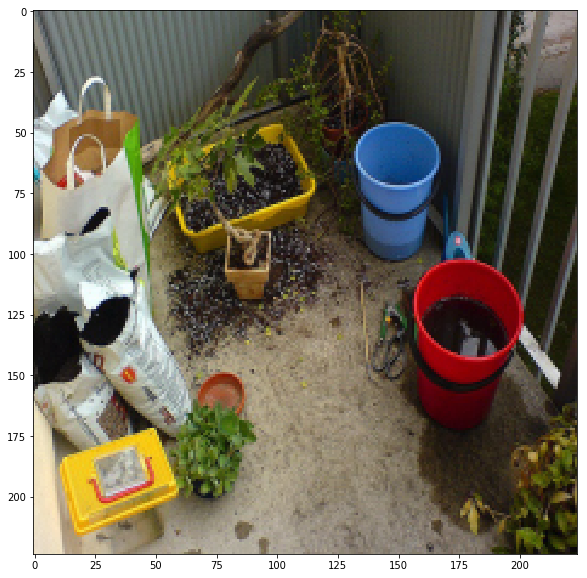

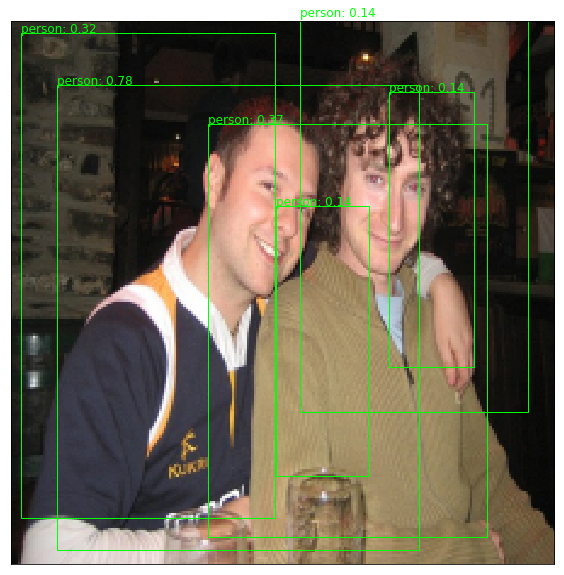

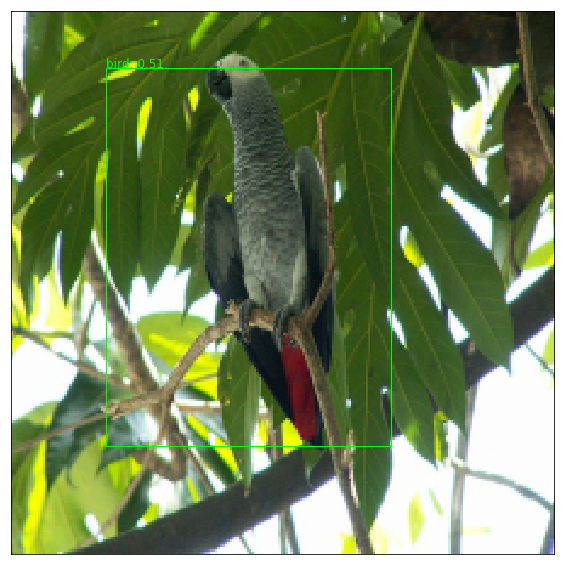

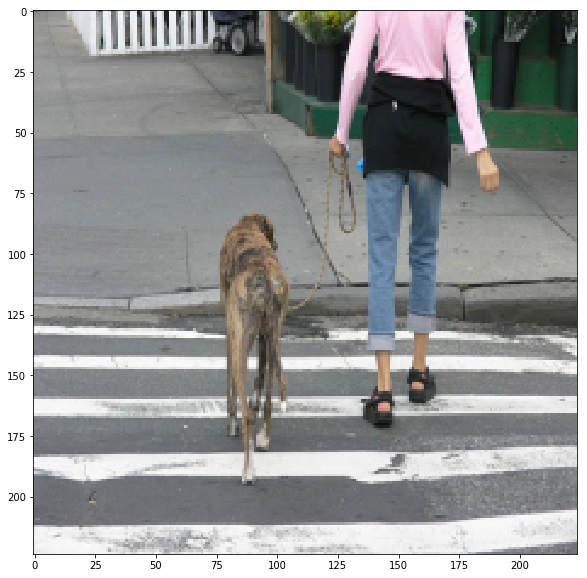

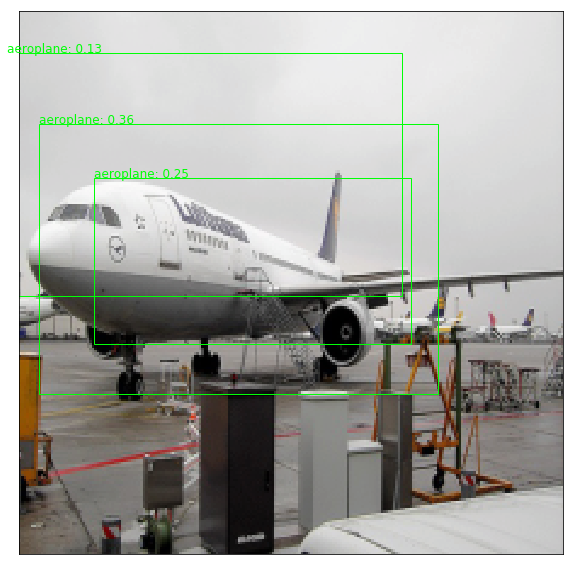

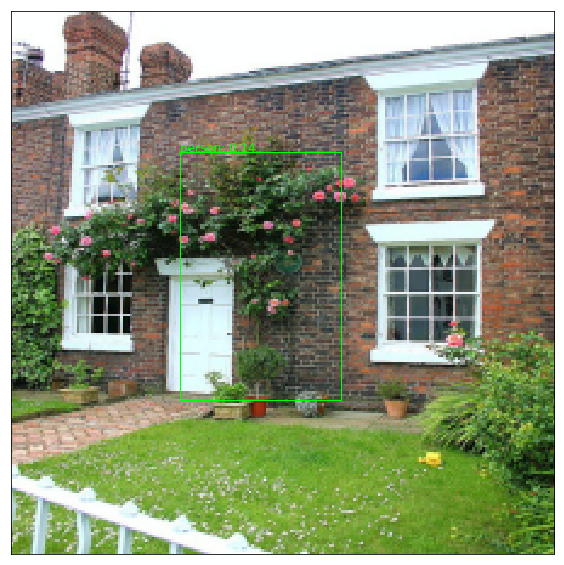

In [43]:
for im, bb, lab in zip(denormed_ims, bb_to_plot, lab_to_plot):
    voc.explore.plot_multiobject_results(im, bb, lab, pm_anc_tensor / 244, label2class, threshold=0.13)